# Gradient based iterative inverse design: Neural adjoint

For many problems, especially with large numbers of parameters, there may be many local minima in the fitness function for iterative inverse design. Even if very large numbers of initial guesses are used, there may be none close enough to the global optimum for a gradient based optimization to converge.

A possible approach is to use a two-step optimization: Start with global, population based optimization, and use the pre-optimized population after only a short optimization as initial set of geometries for the gradient based neural-adjoint loop.

We demonstrate this by using a neural adjoint loop with only few iterations and a low learning rate, such that it does not converge with random initialization. In a secnod step we then use evolutionary optimization from `nevergrad` to pre-optimize a population of $100$ geometries. The neural adjoint method with identical configuration then converges well on this pre-optimized set.

*Note* that for a better readibility of the tutorial, the neural adjoint parts are defined in the `helper` module.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import nevergrad as ng
from concurrent import futures
import h5py


import helper

# Dynamic GPU memory allocation: For local prototyping, don't block GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

2023-07-04 09:11:02.180532: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 09:11:02.668666: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-04 09:11:03.759141: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-04 09:11:03.777656: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

## load the training data

In [2]:
data_path = 'datasets/dataset3_nanoscat.h5'

with h5py.File(data_path, "r") as f:
    geo = np.array(f['geo2d'], dtype=np.float32)
    scatspec = np.array(f['scatspec'], dtype=np.float32)
wavelengths = np.linspace(500, 1000, scatspec.shape[-2])

# lazy normalization
sc_norm = 3100000
scatspec /= sc_norm
geo = geo*2 - 1     # rescale from -1 to 1

sc_train, sc_val, geo_train, geo_val = train_test_split(
                scatspec, geo, test_size=0.1, shuffle=True, random_state=12345)

## load pre-trained forward model and generator

We also adapt the names for readability in the full model.

In [3]:
fwd_model_path = 'models/fwd_model_nanoscat.h5'
gen_model_path = 'models/WGANGP_image_G.h5'

# load pretrained forward model
fwd_model = keras.models.load_model(fwd_model_path)
fwd_model._name = 'fwd'
generator = keras.models.load_model(gen_model_path)
generator._name = 'gen'

latent_dim = generator.input_shape[1]

2023-07-04 09:11:04.600068: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-04 09:11:04.600279: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-04 09:11:04.600406: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## create the full model: Generator + predictor

In [4]:
# build the neural adjoint model
in_z = keras.layers.Input(shape=generator.input_shape[1:], name='latent_in')
geo_G = generator(in_z)
pred_G = fwd_model(geo_G)

NA_fwd_model = keras.models.Model(in_z, pred_G)
NA_fwd_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 latent_in (InputLayer)      [(None, 50)]              0         
                                                                 
 gen (Functional)            (None, 20, 20, 1)         3043585   
                                                                 
 fwd (Functional)            (None, 50, 2)             7142210   
                                                                 
Total params: 10,185,795
Trainable params: 10,145,859
Non-trainable params: 39,936
_________________________________________________________________


### Select a test-spectrum as inverse design target

For simplicity we take a test-sample spectrum

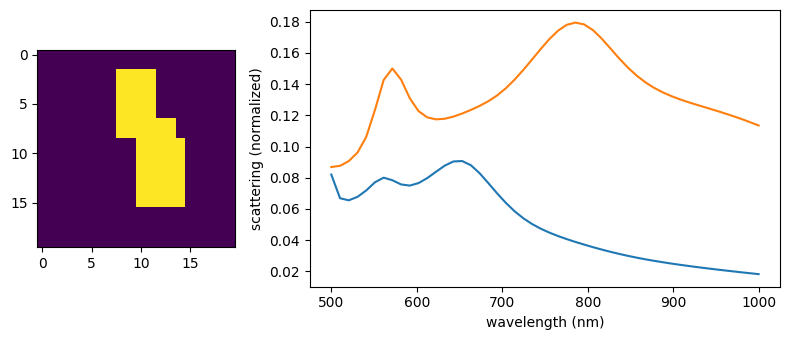

In [5]:
i_test = 0
target = sc_val[i_test]

plt.figure(figsize=(8, 3.5))

plt.subplot(131)
plt.imshow(geo_val[i_test])

plt.subplot2grid((1, 3), (0, 1), colspan=2)
plt.plot(wavelengths, sc_val[i_test])
plt.xlabel("wavelength (nm)")
plt.ylabel("scattering (normalized)")

plt.tight_layout()
plt.show()

## Run WGAN-NA, without pre-optimization

The latent space of the geometry-GAN is normalized in the same way as the input data of the layer-stack example (standardized with mean=0, variance=1). Thus we can run the exact same NA configuration as we used in the layer-stack reflectivity example.

Using a moderate constraint of the geometry, the same distribution as used for the WGAN latent space regularization, and a large enough initial population of trial designs, the neural adjoint usually converges well. In case of convergence problems (e.g. local minima), we show below how to perform global pre-optimization.

In [6]:
# config NA run
N_epoch = 150
N_population = 100
weight_constraint_geo = 0.1
optimizer = keras.optimizers.Adam(learning_rate=0.5)    # the optimizer algo.

# generate random init population of latent vectors (describing geomeotries)
init_z_geo = np.random.normal(
    0, 1, size=[N_population, latent_dim])

# run the NA
loss_tot, inv_design_z_sorted = helper.do_NA(
    init_z_geo, target, optimizer=optimizer, fwd_model=NA_fwd_model, 
    N_epoch=N_epoch, weight_constraint_geo=weight_constraint_geo)


# --- Evaluate (best solutions)
# use best design
predict_z_designs = inv_design_z_sorted[:1]

  0%|          | 0/150 [00:00<?, ?it/s]2023-07-04 09:11:13.546419: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-04 09:11:13.652570: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-04 09:11:15.285550: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x564e1712dce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-04 09:11:15.285579: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-07-04 09:11:15.289071: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-04 09:11:15.412498: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged

## binarize image using best threshold

The geometries generated by the WGAN are already high-contrast, due to the mathematical nature of the the differentiable network model however, they are not exactly binary (black/white). In order to generate a valid geometry we must binarize the generated image. Typically the results are relatively stable, but we can use the forward network to find the best binarization. Using the forward network we evaluate the optimization fitness function for binary geometries made using several trial threshold values. We keep the geoemtry with the best fitness:

In [7]:
def apply_best_threshold(geo, T_target, model_fwd, N_thresholds=25):
    """use the forward net to find best geometry threshold"""
    
    all_geo = []
    all_mse = []
    all_Npert = []
    
    test_thresholds = np.linspace(-1, 1, N_thresholds)
    pbar = tqdm(test_thresholds)
    for th in pbar:
        geo_th = geo.copy()
        geo_th[geo_th < th] = -1
        geo_th[geo_th >= th] = 1
        N_pert = np.count_nonzero(geo_th>0, axis=(1,2))[...,0]

        # calculate loss wrt target
        T_p_th = model_fwd.predict(geo_th, verbose=False)
        mse = np.square(T_p_th - T_target[None,...]).mean(axis=(1,2))
        
        all_mse.append(mse)
        all_geo.append(geo_th)
        all_Npert.append(N_pert)
        
        pbar.set_description("optimizing pattern binarization...")
    
    geo_best = np.array(all_geo)[
                np.argmin(all_mse, axis=0),   # best threshold
                np.arange(len(geo_th)),       # each geometry
                ...]
    threshold_values = test_thresholds[np.argmin(all_mse, axis=0)]
    return geo_best, threshold_values

# optimized patterns: generate then apply threshold
geo_G = generator.predict(predict_z_designs)
geo_th, threshold_values = apply_best_threshold(
            geo_G, target, fwd_model)

# predict all final geometries, calc their loss and sort
pred_sc_th = fwd_model.predict(geo_th)


1/1 [==============================] - 1s 716ms/step


optimizing pattern binarization...: 100%|██████████| 25/25 [00:04<00:00,  6.22it/s]


1/1 [==============================] - 0s 30ms/step


## re-simulate best solution, plot

Let's re-simulate the solution and plot everything.

structure initialization - automatic mesh detection: cube
structure initialization - consistency check: 325/325 dipoles valid
timing for wl=500.00nm - setup: EE 2302.8ms, inv.: 209.8ms, repropa.: 373.6ms (2 field configs), tot: 3108.0ms
timing for wl=510.20nm - setup: EE 14.2ms, inv.: 19.7ms, repropa.: 1.0ms (2 field configs), tot: 35.0ms
timing for wl=520.41nm - setup: EE 6.2ms, inv.: 22.7ms, repropa.: 1.0ms (2 field configs), tot: 29.9ms
timing for wl=530.61nm - setup: EE 9.9ms, inv.: 20.2ms, repropa.: 1.0ms (2 field configs), tot: 31.1ms
timing for wl=540.82nm - setup: EE 9.8ms, inv.: 19.4ms, repropa.: 1.0ms (2 field configs), tot: 30.3ms
timing for wl=551.02nm - setup: EE 14.3ms, inv.: 18.8ms, repropa.: 1.2ms (2 field configs), tot: 34.4ms
timing for wl=561.22nm - setup: EE 13.3ms, inv.: 66.7ms, repropa.: 1.0ms (2 field configs), tot: 81.2ms
timing for wl=571.43nm - setup: EE 10.4ms, inv.: 24.0ms, repropa.: 1.1ms (2 field configs), tot: 35.7ms
timing for wl=581.63nm - setup: EE 12.

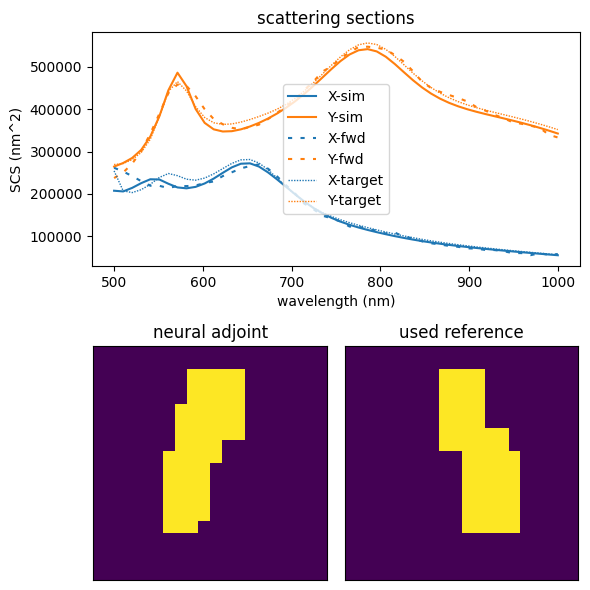

In [8]:
i_opt = 0  # which best one. 0=best, last=least good
sc_recalc = helper.calc_scattering_pygdm(geo_th[i_opt], verbose=1, method='cupy')

plt.figure(figsize=(6, 6))

plt.subplot(211, title='scattering sections')
plt.plot(wavelengths, sc_recalc, label=['X-sim', 'Y-sim'])
plt.gca().set_prop_cycle(None)
plt.plot(wavelengths, sc_norm*pred_sc_th[i_opt], dashes=[2,4], label=['X-fwd', 'Y-fwd'])
plt.gca().set_prop_cycle(None)
plt.plot(wavelengths, sc_norm*target, dashes=[1,1], lw=1, label=['X-target', 'Y-target'])

plt.legend()
plt.xlabel('wavelength (nm)')
plt.ylabel('SCS (nm^2)')

plt.subplot(223, title='neural adjoint'.format(threshold_values[i_opt]))
plt.imshow(geo_th[i_opt])
plt.xticks([]); plt.yticks([])

plt.subplot(224, title='used reference'.format(i_test))
plt.imshow(geo_val[i_test])
plt.xticks([]); plt.yticks([])

plt.tight_layout()
plt.show()

## Run NA on the image pixels

If  instead of using the WGAN latent space, neural adjoint is run on the high dimensional image space (pixel-wise), The design totally fails:

best: T-loss 8.55e-06, constraint_loss 3.00e-01, total 8.55e-06: 100%|██████████| 150/150 [00:13<00:00, 11.43it/s]
optimizing pattern binarization...: 100%|██████████| 25/25 [00:01<00:00, 15.47it/s]


1/1 [==============================] - 0s 100ms/step
best solution from optimization inside extrapolation regime:
structure initialization - automatic mesh detection: cube
structure initialization - consistency check: 580/580 dipoles valid


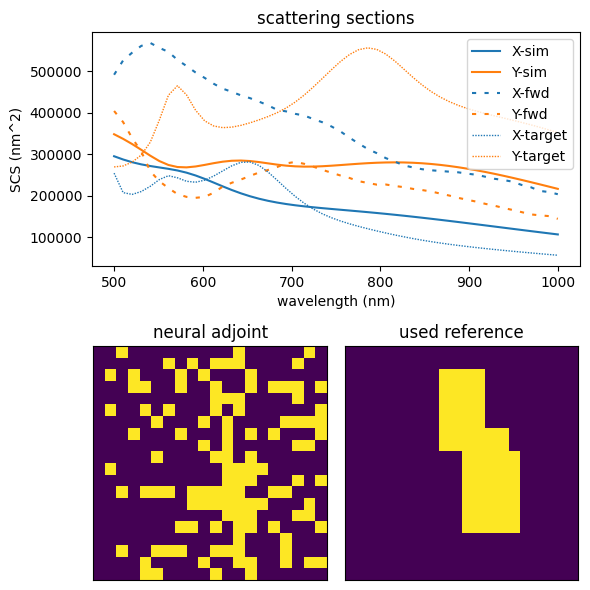

In [9]:
# config NA run
N_epoch = 150
N_population = 100
optimizer = keras.optimizers.Adam(learning_rate=0.5)    # the optimizer algo.

# generate random init population of latent vectors (describing geomeotries)
init_z_geo = np.random.normal(
    0, 1, size=[N_population, *fwd_model.input_shape[1:]])

# run the NA
loss_tot, inv_design_2d_sorted = helper.do_NA(
    init_z_geo, target, optimizer=optimizer, 
    fwd_model=fwd_model, # use the iamge-based forward model here
    N_epoch=N_epoch, weight_constraint_geo=0)


# --- Evaluate best solutions
geo_G = inv_design_2d_sorted[:1]
geo_th, threshold_values = helper.apply_best_threshold(
            geo_G, target, fwd_model)

# predict all final geometries, calc their loss and sort
pred_sc_th = fwd_model.predict(geo_th)

# --- Re-simulate and plot
print("best solution from optimization inside extrapolation regime:")
helper.plot_scattering_design(geo_th[0], geo_val[0], target, sc_norm,
                              pred_sc_th[0], verbose=0, pygdm_method='cupy')

## WGAN-NA without geometry constraint

To demonstrate also the possibility of failing solutions in the WGAN-NA extrapolation-zone, we deliberately initialize the WGAN trial latent variables with an ill matching distribution.

For better readability, the above used code-blocks are defined as functions in the `helper` module.

best: T-loss 7.04e-03, constraint_loss 8.42e+00, total 7.04e-03: 100%|██████████| 50/50 [00:07<00:00,  6.41it/s]


1/1 [==============================] - 0s 17ms/step


optimizing pattern binarization...: 100%|██████████| 25/25 [00:01<00:00, 16.73it/s]


1/1 [==============================] - 0s 27ms/step
best solution from optimization inside extrapolation regime:
structure initialization - automatic mesh detection: cube
structure initialization - consistency check: 850/850 dipoles valid


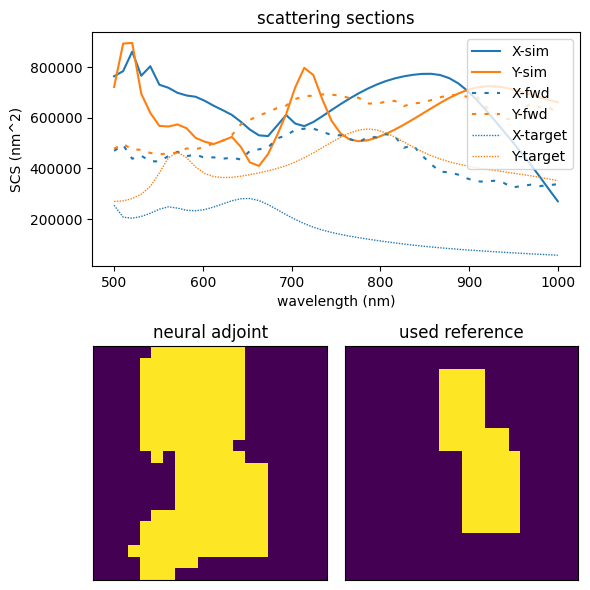

In [10]:
# config NA run
N_epoch = 50
N_population = 100
weight_constraint_geo = 0.0  # deactivate structural constraint
optimizer = keras.optimizers.Adam(learning_rate=0.1)    # the optimizer algo.

# generate random init population of latent vectors (describing geomeotries)
init_z_geo = np.random.normal(
    10, 3, size=[N_population, latent_dim])

# run the NA
loss_tot, inv_design_z_sorted = helper.do_NA(
    init_z_geo, target, optimizer=optimizer, fwd_model=NA_fwd_model, 
    N_epoch=N_epoch, weight_constraint_geo=weight_constraint_geo)


# --- Evaluate best solutions
predict_z_designs = inv_design_z_sorted[:1]
geo_G = generator.predict(predict_z_designs)
geo_th, threshold_values = helper.apply_best_threshold(
            geo_G, target, fwd_model)

# predict all final geometries, calc their loss and sort
pred_sc_th = fwd_model.predict(geo_th)

# --- Re-simulate and plot
print("best solution from optimization inside extrapolation regime:")
helper.plot_scattering_design(geo_th[0], geo_val[0], target, sc_norm,
                              pred_sc_th[0], verbose=0, pygdm_method='cupy')

## Run global pre-optimization with `nevergrad`

Since we have now a uniformized description of the geometry using the WGAN latent space, we can use global pre-optimization in exactly the same way as in the layer-stack example

In [11]:
# define optimization target: MSE between reflectivities
def fitness_func(geo, target_spec):
    # MSE between target and NN-predicted spectrum
    pred_spec = NA_fwd_model.predict(geo)
    mse = np.mean(np.abs(pred_spec - target_spec)**2)
    return mse

# setup the nevergrad paramterization:
args_geo_ng = ng.p.Array(
    shape=[1, *NA_fwd_model.input_shape[1:]],
    lower=-1.5, upper=1.5
)

# wrap optimized and fixed arguments together
instru = ng.p.Instrumentation(
    geo=args_geo_ng,     # optimization args (geometry)
    target_spec=target,  # additional (fixed) arg (design target spectrum)
)

# =============================================================================
# run optimization
# =============================================================================
N_population = 100
N_func_eval = 100

optim_algo = ng.families.DifferentialEvolution(crossover="twopoints", popsize=N_population)
NG_optimizer = optim_algo(instru, budget=N_func_eval, num_workers=30)

with futures.ThreadPoolExecutor(max_workers=30) as executor:
    x_opt = NG_optimizer.minimize(fitness_func, executor=executor, verbosity=0)

print('best fitness:', x_opt.loss)

1/1 [==============================] - 0s 60ms/step
best fitness: 0.0007366894278675318


## Extract optimizer population

After a short global optimization run, we use the population of the global optimizer as initial set of test-solutions for the neural adjoint loop.

As shown below, the best solution from evolutionary optimization is already close to the design. Optimizing the population using gradients will rapidly converge.

1/1 [==============================] - 0s 16ms/step


optimizing pattern binarization...: 100%|██████████| 25/25 [00:01<00:00, 14.76it/s]


1/1 [==============================] - 0s 23ms/step
best solution after pre-optimization:
structure initialization - automatic mesh detection: cube
structure initialization - consistency check: 260/260 dipoles valid


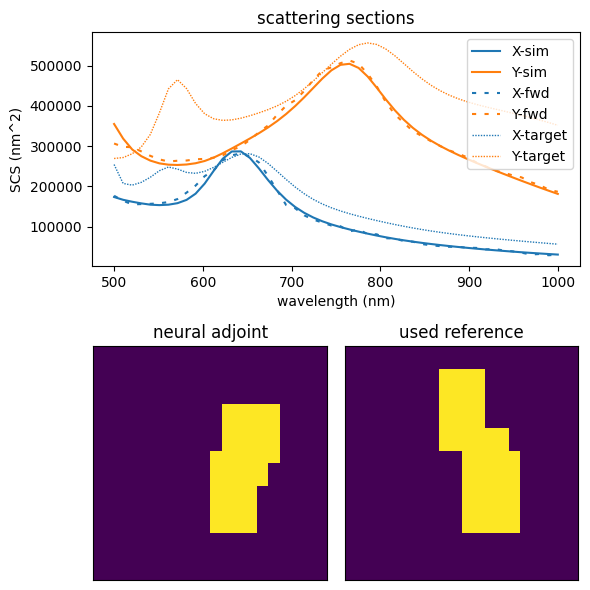

In [12]:
pop = NG_optimizer.population

# extract all designs in the pre-optimized population
init_geo_preopt = []
for k in pop:
    # each individual is a NG instrumentation. 
    # The fitness-func argument is `geo` --> get all values:
    geo_design = np.array(pop[k][1]['geo'].value)
    init_geo_preopt.append(geo_design[0])
init_geo_preopt = np.array(init_geo_preopt)

# Sort pre-optimized results and calculate the spectra of the 6 best (with pymoosh)
loss_total, init_geo_preopt_sorted = helper.sort_NA_results(
        tf.convert_to_tensor(init_geo_preopt, dtype=tf.float32), 
        target, weight_constraint_geo, NA_fwd_model)

# --- Evaluate best solutions
predict_z_designs = init_geo_preopt_sorted[:1]
geo_G = generator.predict(predict_z_designs)
geo_th, threshold_values = helper.apply_best_threshold(
            geo_G, target, fwd_model)

# predict all final geometries, calc their loss and sort
pred_sc_th = fwd_model.predict(geo_th)

# --- Re-simulate and plot
print("best solution after pre-optimization:")
helper.plot_scattering_design(geo_th[0], geo_val[0], target, sc_norm,
                              pred_sc_th[0], verbose=0, pygdm_method='cupy')

## Run NA on pre-optimized design-set

We run the NA with the same configuration as above, but instead of random initial geometries, we use the pre-optimized set of initial designs. With this initial set, the NA converges significantly faster.

best: T-loss 1.45e-05, constraint_loss 1.34e-02, total 1.45e-05: 100%|██████████| 50/50 [00:04<00:00, 12.09it/s]


1/1 [==============================] - 0s 16ms/step


optimizing pattern binarization...: 100%|██████████| 25/25 [00:01<00:00, 15.62it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step
best solution after neural adjoint with pre-optimization:
structure initialization - automatic mesh detection: cube
structure initialization - consistency check: 330/330 dipoles valid


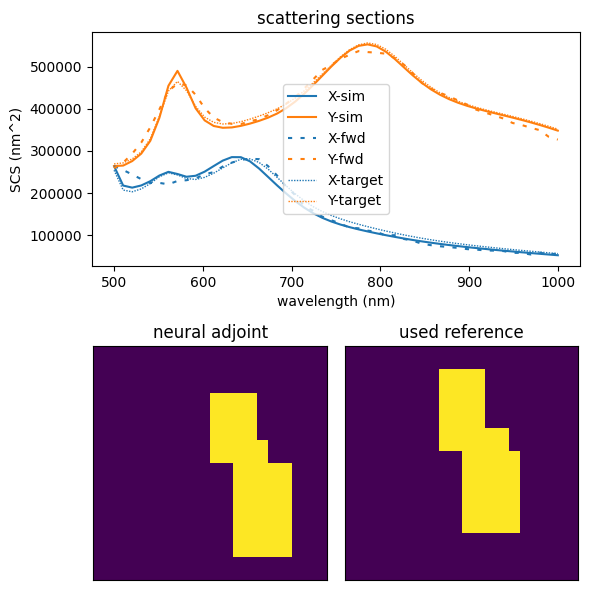

In [13]:
# config NA run
N_epoch = 50
weight_constraint_geo = 0.0
optimizer = keras.optimizers.Adam(learning_rate=0.1)    # the optimizer algo.

# run the NA
loss_tot, inv_design_z_sorted = helper.do_NA(
    init_geo_preopt, target, optimizer=optimizer, fwd_model=NA_fwd_model, 
    N_epoch=N_epoch, weight_constraint_geo=weight_constraint_geo)


# --- Evaluate best solutions
predict_z_designs = inv_design_z_sorted[:1]
geo_G = generator.predict(predict_z_designs)
geo_th, threshold_values = helper.apply_best_threshold(
            geo_G, target, fwd_model)

# predict all final geometries, calc their loss and sort
pred_sc_th = fwd_model.predict(geo_th)

# --- Re-simulate and plot
print("best solution after neural adjoint with pre-optimization:")
helper.plot_scattering_design(geo_th[0], geo_val[0], target, sc_norm,
                              pred_sc_th[0], verbose=0, pygdm_method='cupy')

## Hand-draw spectral design target

We can define hand-drawn design targets or other fitness functions like maximization of a single wavelength, maximize the ratio of the cross-polarization response, etc... 

And example for a hand-drawn target:

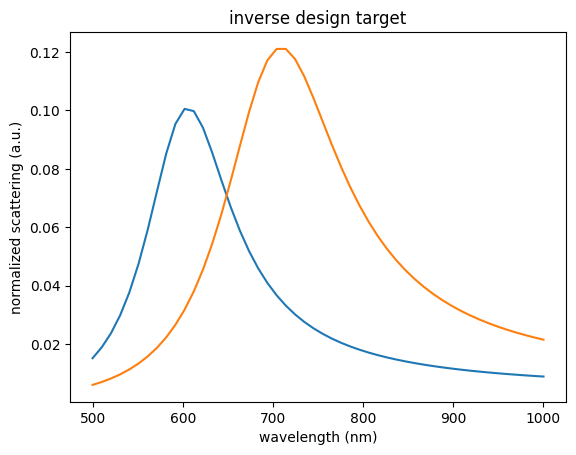

In [35]:
# --- 'hand-drawn' spectrum: two Lorentzians
def lorentzian(x, A, x0, gamma):
    x = 1239/x; x0 = 1239/x0     # x, x0: nm to eV
    return np.abs(A**0.5 * x0 * gamma / ( x0**2 - x**2 - 1j*x*gamma))**2

target = np.stack([
        lorentzian(wavelengths, .10, 600, .4),
        lorentzian(wavelengths, .12, 700, .4),
              ], axis=1)


# --- plot
plt.figure()
plt.title('inverse design target')
plt.plot(wavelengths, target[:,0])
plt.plot(wavelengths, target[:,1])
plt.xlabel('wavelength (nm)')
plt.ylabel('normalized scattering (a.u.)')
plt.show()

best: T-loss 3.27e-04, constraint_loss 1.52e-03, total 4.79e-04: 100%|██████████| 150/150 [00:12<00:00, 12.17it/s]


1/1 [==============================] - 0s 17ms/step


optimizing pattern binarization...: 100%|██████████| 25/25 [00:01<00:00, 15.85it/s]


1/1 [==============================] - 0s 91ms/step
best solution from optimization inside extrapolation regime:
structure initialization - automatic mesh detection: cube
structure initialization - consistency check: 200/200 dipoles valid


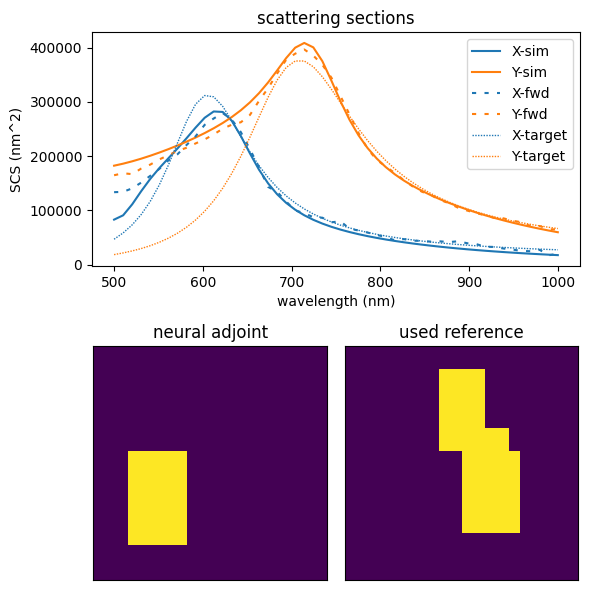

In [36]:
# config NA run
N_epoch = 150
N_population = 100
weight_constraint_geo = 0.1
optimizer = keras.optimizers.Adam(learning_rate=0.5)    # the optimizer algo.

# generate random init population of latent vectors (describing geomeotries)
init_z_geo = np.random.normal(
    0, 1, size=[N_population, latent_dim])

# run the NA
loss_tot, inv_design_z_sorted = helper.do_NA(
    init_z_geo, target, optimizer=optimizer, fwd_model=NA_fwd_model, 
    N_epoch=N_epoch, weight_constraint_geo=weight_constraint_geo)


# --- Evaluate best solutions
predict_z_designs = inv_design_z_sorted[:1]
geo_G = generator.predict(predict_z_designs)
geo_th, threshold_values = helper.apply_best_threshold(
            geo_G, target, fwd_model)

# predict all final geometries, calc their loss and sort
pred_sc_th = fwd_model.predict(geo_th)

# --- Re-simulate and plot
print("best solution from optimization inside extrapolation regime:")
helper.plot_scattering_design(geo_th[0], geo_val[0], target, sc_norm,
                              pred_sc_th[0], verbose=0, pygdm_method='cupy')